In [1]:
import os
import ot
import ot.plot
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from sklearn.metrics import f1_score
from tqdm import tqdm

67


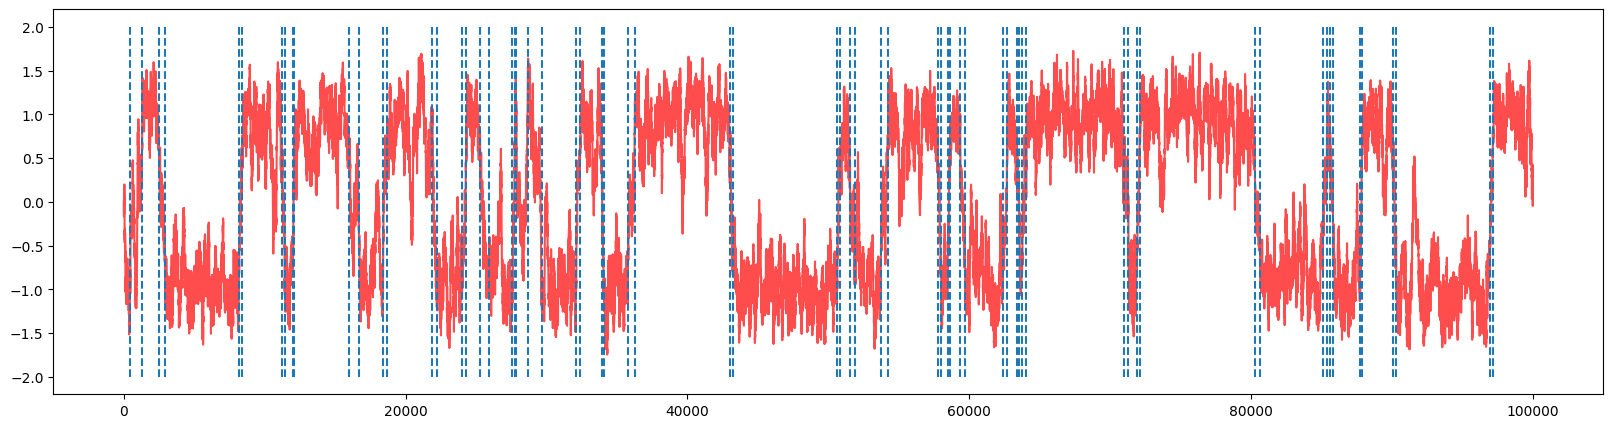

In [2]:
data = np.loadtxt("Langevin_1D.txt")
plt.figure(1, figsize=(20, 5))
plt.plot(np.arange(100000), data, 'r', alpha=0.7)
cp = np.loadtxt("ChangePts.txt")

NumPts = 100000
Points_per_bin = 100
data = data[0:NumPts]
for c in cp:
    plt.vlines(c, -2, 2, linestyle='dashed')
print(len(cp))

#plt.savefig('Plot of data.png')

In [31]:
def qW2(data, n, s):
    cpd_stat = np.zeros(len(data)// s, )
    count = 0
    for i in tqdm(range(0, len(data)-s, s),  desc = 'W2=>  n: ' + str(n)):
        if i<n or i>= len(data)- n:
            cpd_stat[count] = 0
        else:
            x, y = data[i-n:i], data[i: i+n]
            cpd_stat[count] = ot.emd2_1d(x, y)
        count += 1
    return cpd_stat  

def make_graph(samples, n, q):
    plt.clf()
    fig, ax = plt.subplots()
    fig.set_size_inches(24, 5)
    
    quantile = np.quantile(samples, q)
    
    peaks, _ = find_peaks(samples, height=quantile, width=0)
    
    ax.vlines(peaks*n, -2, 2, color='purple', linestyle='dashed')
    
    ax.plot(np.arange(NumPts), data, 'r', alpha=0.7)
    plt.title("Langevin Trajectory with labelled change points")


def statistic(samples, true_cp, n, s, q):
    detected_cps = qW2(samples, n, s)
    quantile = np.quantile(detected_cps, q)
    peaks, _ = find_peaks(detected_cps, height=quantile, width=0)
    
    #f1_score(peaks, y_pred_empty)
    TP = 0
    
    for i in peaks:
        for j in true_cp:
            if abs(i*n - j) < n:
                TP+=1
                break
    
    FP = len(peaks) - TP
    FN = len(true_cp) - TP
    
    #print("True Positives:", TP)
    #print("False Positives:", FP)
    #print("False Negatives:", FN)
    
    F1 = (2*TP)/(2*TP+FN+FP)
    
    
    return F1

In [136]:
cps_W2 = qW2(data, 100, 100)

W2=>  n: 100: 100%|█████████████████████████| 999/999 [00:00<00:00, 5222.74it/s]


45


<Figure size 640x480 with 0 Axes>

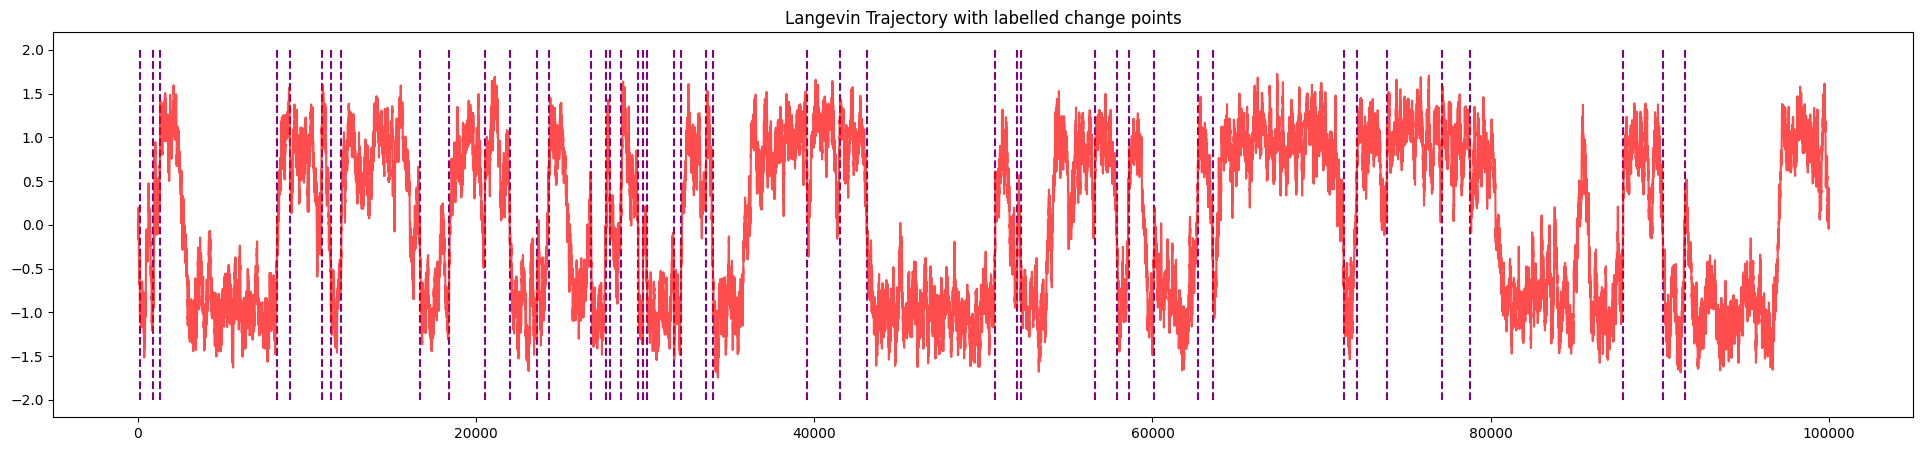

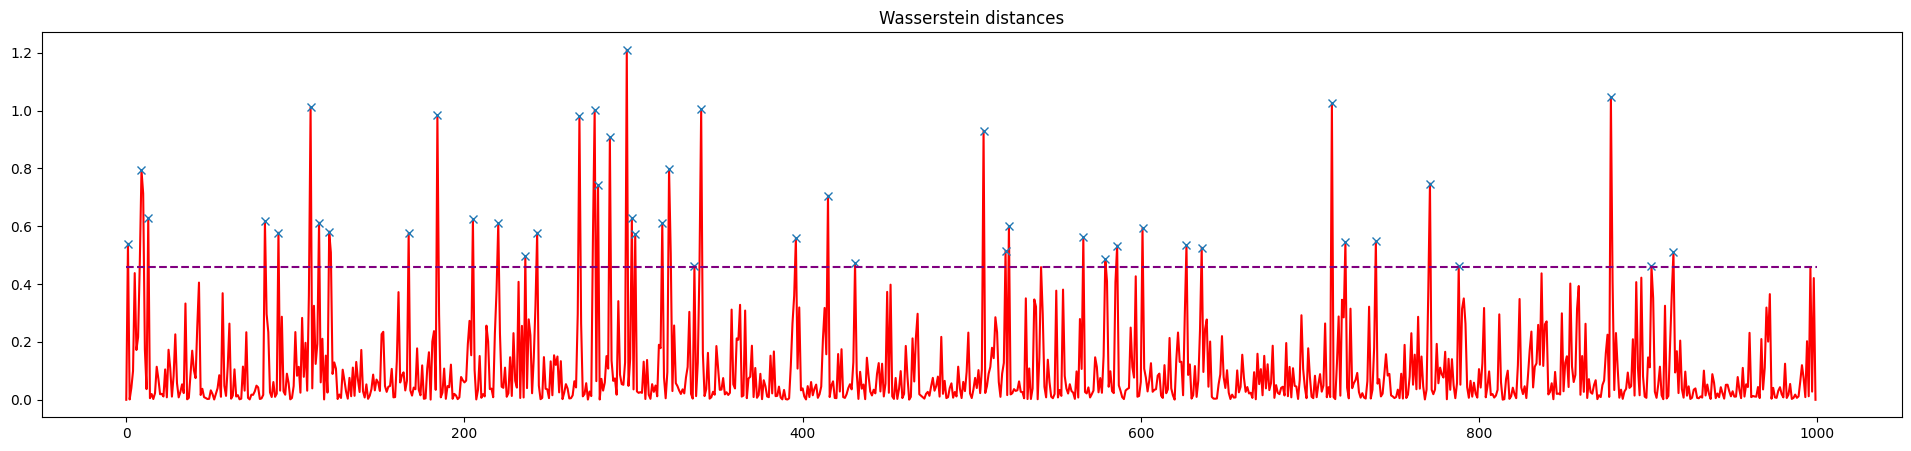

In [137]:
make_graph(cps_W2, 100, 0.95)

fig, ax = plt.subplots()
fig.set_size_inches(24, 5)

quantile = np.quantile(cps_W2, 0.95)

peaks, _ = find_peaks(cps_W2, height=quantile, width=0)
print(len(peaks))
#ax.figure(1, figsize=(24, 5))
ax.plot(np.arange(NumPts/Points_per_bin), cps_W2, 'r')
ax.plot(peaks, cps_W2[peaks], "x")
plt.title("Wasserstein distances")

quantile_top = np.quantile(cps_W2, 0.95)
plt.hlines(quantile_top, 0, NumPts/Points_per_bin, color='purple', linestyle='dashed')

In [30]:
t = statistic(data, cp, 100, 100, 0.95)
print(t)

W2=>  n: 100: 100%|█████████████████████████| 999/999 [00:00<00:00, 5136.51it/s]

True Positives: 21
False Positives: 24
False Negatives: 46
0.375


In [48]:
bin_size = [50,100,250,500,1000]
quantile = [0.75,0.80,0.85,0.90,0.95,0.97]
heatmap = []
values = []

for i in range(len(bin_size)):
    for j in range(len(quantile)):
        F1_score = statistic(data, cp, bin_size[i], 100, quantile[j])
        values.append(F1_score)
    heatmap.append(values)
    values = []

W2=>  n: 1000: 100%|████████████████████████| 999/999 [00:00<00:00, 2987.81it/s]

[[0.06201550387596899, 0.05172413793103448, 0.05128205128205128, 0.024844720496894408, 0.034482758620689655, 0.020833333333333332], [0.3076923076923077, 0.3364485981308411, 0.37158469945355194, 0.43243243243243246, 0.375, 0.3125], [0.14906832298136646, 0.13793103448275862, 0.12213740458015267, 0.14035087719298245, 0.06521739130434782, 0.06896551724137931], [0.05084745762711865, 0.01834862385321101, 0.018867924528301886, 0.0, 0.0, 0.0], [0.038834951456310676, 0.04, 0.042105263157894736, 0.04395604395604396, 0.024691358024691357, 0.02631578947368421]]


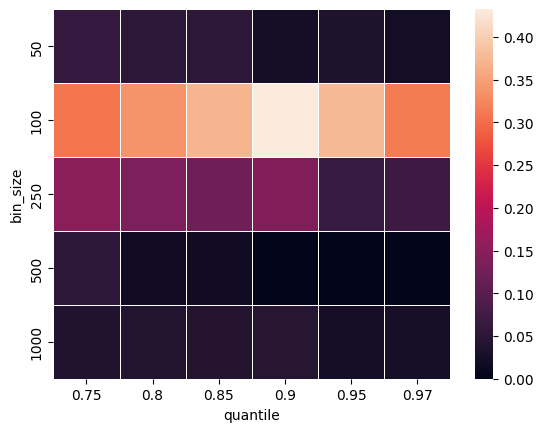

In [58]:
import pandas as pd
df = pd.DataFrame(heatmap, index = [i for i in bin_size],
                  columns = [i for i in quantile])
ax = sns.heatmap(df, linewidth=0.5)

plt.xlabel('quantile')
plt.ylabel('bin_size')
plt.show()